# Background Detail Binary - Story 1

This notebook assesses inter-annotator agreement for the background detail/information amount score. 
It imports JSON files to perform a number of statistical tests to assess inter-annotator agreement. 

##### Imports and packages

In [2]:
# Imports and Packages:

import json # json library
import os # for list directories 

from collections import Counter # counter library
import re # regex

import numpy as np 
import math
import matplotlib.pyplot as plt

import itertools
from itertools import permutations # library to print permutations
from itertools import combinations # library to print combinations

import sklearn # sklearn for inter-annotation kappa scores
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

import scipy.stats
from scipy.stats import mode 
from scipy.stats import zscore # normalise data
from scipy.stats import mannwhitneyu # for Mann-Whitney U test
from scipy.stats import ttest_ind # independent t-test
from scipy.stats import spearmanr # spearmans rank
from scipy.stats import pearsonr # pearson's r


##### Import JSON data

In [3]:
# Import JSON data from Prolific Study

path_to_jsonFiles = "Annotations_Prolific/Background_Detail_Binary_Story1/Processed_Data" # This is the folder with the json data files
corpus = {} # init a dict to hold each json data file
participantNum = 1 # init a participant num counter

for file in sorted(os.listdir(path_to_jsonFiles)):
    if file.endswith('.json'): # check that the file has a json extension (to circumvent hidden .DS_store files)
        full_file_name = "%s/%s" % (path_to_jsonFiles, file)
        with open(full_file_name, 'r') as fi:
            storyName = "participant" + str(participantNum)
            story_data = json.load(fi)
            corpus[storyName] = story_data
        participantNum += 1
    
# all_stories holds all the json data files, with key "storyN" and value is the read in json file



In [4]:
# check that the data was read in correctly
#corpus['participant1']

##### Get annotator pair combinations as pairs of names in a list

In [5]:
# Combinations of annotators:
# Function to get the combinations of all participants

def get_combinations_of_annotators(all_annotation_data):
    """
    Takes: a dict containing all annotation data - this is the input of reading in all json files,
            as is done above.
    Returns: a list of tuples containing pairs of strings that indicate annotators. In other words, a list of 
            annotator pairs.
    """
    annotators = [] # init a list to store annotators
    annotator_pairs = [] # init a list to store all combination pairs
    
    for annotator, annotation_data in all_annotation_data.items():
        annotators.append(annotator)
     
    combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
    
    for ann in list(combs):
        annotator_pairs.append(ann)
    
    return annotator_pairs



In [6]:
# Get all annotator combinations
combinations_all_participants = get_combinations_of_annotators(corpus)


##### Store the annotation values per annotator in a dictionary and list of lists for easier analysis

In [7]:
# get a list of all values per participant, put in a dict "background_values"

background_values = {}

for participant, story_info in corpus.items():
    values = [] # init values list
    for page, page_info in story_info.items():
        for panel, panel_info in page_info.items():
            background_info = panel_info["background/setting"]
            value = float(background_info["information_amount"])
            values.append(value)
    
    background_values[participant] = values
    
#background_values  


In [8]:
# background_values

# put all sets of background values into a list of lists

list_of_lists_of_all_participant_values = []
for participant, values_list in background_values.items():
    #print(participant)
    #print(values_list)
    list_of_lists_of_all_participant_values.append(values_list)
    
# print(len(list_of_lists_of_all_participant_values))


### Krippendorff's Alpha

##### Function to calculate Krippendorff's Alpha

In [41]:
# Krippendorff's Alpha - Inter-rater agreement measure

# Code from https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Python implementation of Krippendorff's alpha -- inter-rater reliability
    (c)2011-17 Thomas Grill (http://grrrr.org)
    Python version >= 2.4 required

    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to 
    coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.


##### Krippendorff's Alpha result for all-against-all annotators, using the above function 

In [43]:
kalpha = krippendorff_alpha(list_of_lists_of_all_participant_values, nominal_metric) # get the k alpha for each ind agent
print(kalpha)


0.2220271193054335


In [336]:
#print(list_of_lists_of_all_participant_values)

##### Krippendorff's Alpha result for all-against-all annotators, using the Krippendorff 0.7.0 Python package

In [45]:
# Another version 

import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

print(krippendorff.alpha(list_of_lists_of_all_participant_values, level_of_measurement="nominal"))


0.22202711930543362


##### Krippendorff's Alpha results for all individual annotator pairs

In [341]:
KA_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    KA_value = krippendorff_alpha([background_values[ann1], background_values[ann2]])
    KA_values.append(KA_value)
    
print("Pairwise KA values: \n")
print(KA_values)
print("\n")
print("mean: ", np.mean(KA_values))
print("std: ", np.std(KA_values))

#print(background_values[ann1])

Pairwise KA values: 

[0.5434782608695652, 0.34375, 0.015625, 0.25, 0.5476923076923077, 0.28409090909090906, 0.28, 0.6174089068825911, 0.5, 0.3942307692307693, -0.125, -0.050000000000000044, 0.2325581395348838, 0.1796875, 0.5333333333333333, 0.3181818181818181, 0.34375, -0.5303643724696356, 0.18181818181818177, 0.18947368421052635, 0.28, 0.15625, -0.002272727272727204, 0.18181818181818177, -0.020242914979757165, 0.193103448275862, 0.0117647058823529, -0.18125000000000013, 0.125, -0.14777327935222684, 0.19941348973607032, 0.23481781376518218, -0.2886363636363636, 0.26171875, 0.2588235294117647, 0.2651113467656415, -0.0250312891113893, 0.5655172413793104, 0.4457478005865102, 0.1923076923076923, 0.2124999999999999, -0.14777327935222684, 0.08695652173913038, -0.002272727272727204, 0.630859375]


mean:  0.18969270564590068
std:  0.24576272195333793


### Per-panel analysis of annotator agreement

##### Get all annotators raw values and z-score normalised values per panel 

In [12]:
# z-score normalisation - normalise the raw background values

zscore_values = {}

for participant, values in background_values.items():
    int_values =  [float(i) for i in values]
    normalised_values = zscore(int_values)
    
    zscore_values[participant] = list(normalised_values)
    
  

In [13]:
# Get each zscore value per panel 

zscores_per_panel = {}

for participant, values in zscore_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if zscores_per_panel.get(panelName) == None:
            zscores_per_panel[panelName] = []
        if zscores_per_panel.get(panelName) != None:
            zscores_per_panel[panelName].append(val)
        panelNum += 1


In [14]:

# Get raw background values value per panel 

raw_value_per_panel = {}

for participant, values in background_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if raw_value_per_panel.get(panelName) == None:
            raw_value_per_panel[panelName] = []
        if raw_value_per_panel.get(panelName) != None:
            raw_value_per_panel[panelName].append(val)
        panelNum += 1



##### Calculate percentage of agreement between annotators, per panel 

In [15]:
# Get percentage agree from background_values

percentage_agreement_per_panel = {}

for panelNum, values in raw_value_per_panel.items():
    Empty_counter = 0
    Detail_counter = 0
    for val in values:
        if val == 1.0:
            Empty_counter += 1
        if val == 5.0:
            Detail_counter += 1
    #print("Empty: ", Empty_counter)
    #print("Detail: ", Detail_counter)
    if Empty_counter == 0:
        percentage_agree = 1.0
    if Detail_counter == 0:
        percentage_agree = 1.0
    else:
        if Empty_counter > Detail_counter:
            percentage_agree = abs(Empty_counter*.10)
        else:
            percentage_agree = abs(Detail_counter*.10)
    #print(percentage_agree)
    percentage_agreement_per_panel[panelNum] = {"Empty" : Empty_counter, "Detail" : Detail_counter, "Agreement" :percentage_agree}



In [16]:
percentage_agreement_per_panel


{1: {'Empty': 6, 'Detail': 4, 'Agreement': 0.6000000000000001},
 2: {'Empty': 5, 'Detail': 5, 'Agreement': 0.5},
 3: {'Empty': 3, 'Detail': 7, 'Agreement': 0.7000000000000001},
 4: {'Empty': 10, 'Detail': 0, 'Agreement': 1.0},
 5: {'Empty': 7, 'Detail': 3, 'Agreement': 0.7000000000000001},
 6: {'Empty': 8, 'Detail': 2, 'Agreement': 0.8},
 7: {'Empty': 7, 'Detail': 3, 'Agreement': 0.7000000000000001},
 8: {'Empty': 7, 'Detail': 3, 'Agreement': 0.7000000000000001},
 9: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 10: {'Empty': 2, 'Detail': 8, 'Agreement': 0.8},
 11: {'Empty': 4, 'Detail': 6, 'Agreement': 0.6000000000000001},
 12: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 13: {'Empty': 10, 'Detail': 0, 'Agreement': 1.0},
 14: {'Empty': 4, 'Detail': 6, 'Agreement': 0.6000000000000001},
 15: {'Empty': 8, 'Detail': 2, 'Agreement': 0.8},
 16: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 17: {'Empty': 9, 'Detail': 1, 'Agreement': 0.9},
 18: {'Empty': 0, 'Detail': 10, 'Agreement': 1.0},
 

In [17]:

panel_percentage_agreement = {}

for panel, info in percentage_agreement_per_panel.items():
    panel_percentage_agreement[panel] = info["Agreement"]



In [18]:
panel_percentage_agreement

{1: 0.6000000000000001,
 2: 0.5,
 3: 0.7000000000000001,
 4: 1.0,
 5: 0.7000000000000001,
 6: 0.8,
 7: 0.7000000000000001,
 8: 0.7000000000000001,
 9: 0.9,
 10: 0.8,
 11: 0.6000000000000001,
 12: 0.9,
 13: 1.0,
 14: 0.6000000000000001,
 15: 0.8,
 16: 0.9,
 17: 0.9,
 18: 1.0,
 19: 0.7000000000000001,
 20: 0.9,
 21: 0.6000000000000001,
 22: 0.5,
 23: 0.6000000000000001,
 24: 0.7000000000000001,
 25: 0.6000000000000001,
 26: 0.5,
 27: 0.7000000000000001,
 28: 0.7000000000000001,
 29: 0.7000000000000001,
 30: 1.0,
 31: 0.6000000000000001,
 32: 1.0}

##### Sort by least agreed to most agreed panel

In [19]:
import operator
sorted_agreement_per_panel = sorted(panel_percentage_agreement.items(), key=operator.itemgetter(1))

print(sorted_agreement_per_panel)



[(2, 0.5), (22, 0.5), (26, 0.5), (1, 0.6000000000000001), (11, 0.6000000000000001), (14, 0.6000000000000001), (21, 0.6000000000000001), (23, 0.6000000000000001), (25, 0.6000000000000001), (31, 0.6000000000000001), (3, 0.7000000000000001), (5, 0.7000000000000001), (7, 0.7000000000000001), (8, 0.7000000000000001), (19, 0.7000000000000001), (24, 0.7000000000000001), (27, 0.7000000000000001), (28, 0.7000000000000001), (29, 0.7000000000000001), (6, 0.8), (10, 0.8), (15, 0.8), (9, 0.9), (12, 0.9), (16, 0.9), (17, 0.9), (20, 0.9), (4, 1.0), (13, 1.0), (18, 1.0), (30, 1.0), (32, 1.0)]


##### List the means of all z-score normalised annotator scores per panel

In [20]:
# just means in a list without panel - 1-5

binary_story1_just_means_normalised = []

for panel, values in zscores_per_panel.items():
    mean_value = np.mean(values)
    binary_story1_just_means_normalised.append(mean_value)


In [21]:
binary_story1_just_means_normalised

[0.08152471746731149,
 0.2585543735167044,
 0.6694906890510783,
 -0.7962520301624106,
 -0.1849239414807889,
 -0.3853157146280367,
 -0.1617110605094836,
 -0.1950767107206671,
 -0.5857074877752846,
 1.034590302046138,
 0.5339665225803429,
 -0.5958602570151628,
 -0.7962520301624106,
 0.42759342632517294,
 -0.3853157146280367,
 -0.5857074877752846,
 -0.5857074877752846,
 1.5103942242570243,
 0.755192618450216,
 -0.5857074877752846,
 0.44961702817213817,
 0.23907248578501203,
 0.42759342632517294,
 -0.1950767107206671,
 0.610593874780337,
 0.22720165317792507,
 0.7148764079958985,
 -0.1629003396338236,
 -0.1629003396338236,
 -0.7962520301624106,
 0.016657110790799002,
 -0.7962520301624106]

In [22]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)

    

In [23]:
# just stds in a list without panel

binary_story1_just_stds_normalised = []

for panel, std in STD_per_panel.items():
    binary_story1_just_stds_normalised.append(std)
    

##### List the standard deviations of all z-score normalised annotator scores per panel

In [24]:
binary_story1_just_stds_normalised

[1.11686898829948,
 0.9521142620942208,
 0.7991146655732223,
 0.31296368351888443,
 0.7134721309533874,
 0.6479731360606931,
 0.9135117561842465,
 0.8178084130517292,
 0.5003820170382777,
 1.1019391713889948,
 1.198579728269121,
 0.5931408581724975,
 0.31296368351888443,
 0.7581708488730837,
 0.6479731360606931,
 0.5003820170382777,
 0.5003820170382777,
 0.7069227398564856,
 1.1585021495394443,
 0.5003820170382777,
 0.892763609408292,
 0.8963808020693567,
 0.7581708488730837,
 0.8178084130517292,
 1.282420905570211,
 0.8550652737226191,
 1.0597384754697179,
 0.870761726947031,
 0.870761726947031,
 0.31296368351888443,
 0.8024659591939612,
 0.31296368351888443]

##### Reformat binary scores into 0 and 1 (instead of the raw input of 1 and 5) and calculate percent disagreement between all annotators 

In [25]:
# convert values from 1 -> 0 and 5 -> 1

values_reformat = {}

for panel, values in raw_value_per_panel.items():
    reassigned_values = []
    for val in values:
        if val == 1.0:
            reassigned_values.append(0)
        if val == 5.0: 
            reassigned_values.append(1)
    values_reformat[panel] = reassigned_values
    
values_reformat


{1: [0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
 2: [0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
 3: [1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 5: [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
 6: [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 7: [0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
 8: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
 9: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 10: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
 11: [1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 13: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 14: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
 15: [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 16: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 17: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 18: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 19: [1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 20: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 21: [1, 0, 0, 1, 1, 1, 1, 0, 1, 0],
 22: [0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
 23: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
 24: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
 25: [1, 1, 0, 1, 0, 0, 0, 1, 1, 1],
 26: [1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
 27: [1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
 28: [0, 0

In [26]:
# just means in a list without panel

binary_story1_just_means = []

for panel, values in values_reformat.items():
    mean_value = np.mean(values)
    binary_story1_just_means.append(mean_value)


In [27]:
binary_story1_just_means


[0.4,
 0.5,
 0.7,
 0.0,
 0.3,
 0.2,
 0.3,
 0.3,
 0.1,
 0.8,
 0.6,
 0.1,
 0.0,
 0.6,
 0.2,
 0.1,
 0.1,
 1.0,
 0.7,
 0.1,
 0.6,
 0.5,
 0.6,
 0.3,
 0.6,
 0.5,
 0.7,
 0.3,
 0.3,
 0.0,
 0.4,
 0.0]

## Pearson's r and Spearman's rank between annotator pairs

##### Calculate Pearson's r scores between each annotator pair

In [28]:

# Pearson's r function 

def get_pearsonsr(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    
    # compare samples
    coef, p = pearsonr(values_Ann1, values_Ann2)
    print('Pearsons correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    
    return coef, p


In [56]:

corr = 0
not_corr = 0

pearsons_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values[ann1], background_values[ann2])
    if p > 0.01:
        not_corr +=1
    if p < 0.01:
        corr +=1
    pearsons_values.append(pearsons_value)

print("\n")    
print("all pairwise Pearson's r scores: \n")
print(pearsons_values)
print("\n")  
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(pearsons_values))
print("std: ", np.std(pearsons_values))



Pearsons correlation coefficient: 0.572
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.413
Samples are uncorrelated (fail to reject H0) p=0.019
Pearsons correlation coefficient: 0.108
Samples are uncorrelated (fail to reject H0) p=0.555
Pearsons correlation coefficient: 0.284
Samples are uncorrelated (fail to reject H0) p=0.115
Pearsons correlation coefficient: 0.555
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.279
Samples are uncorrelated (fail to reject H0) p=0.122
Pearsons correlation coefficient: 0.444
Samples are uncorrelated (fail to reject H0) p=0.011
Pearsons correlation coefficient: 0.639
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.548
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.397
Samples are uncorrelated (fail to reject H0) p=0.025
Pearsons correlation coefficient: 0.065
Samples are uncorrelated (fail to reject H0) p=0.725
Pearsons correlat

##### Calculate Spearman's rank between each annotator pair

In [63]:
# Spearman's rank function 

def get_spearmans_rank(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    # compare samples
    coef, p = spearmanr(values_Ann1, values_Ann2)
    print('%.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
    return coef, p



In [342]:

corr = 0
not_corr = 0

spearmans_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    spearmans_value, p = get_spearmans_rank(background_values[ann1], background_values[ann2])
    if p > 0.01:
        not_corr +=1
    if p < 0.01:
        corr +=1
    spearmans_values.append(spearmans_value)
print("********************")

print("\n")    
print("all pairwise Spearman's rank scores: \n")

print(spearmans_values)
print("\n")  
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(spearmans_values))
print("std: ", np.std(spearmans_values))


participant1 and participant2:
0.572
Samples are correlated (reject H0) p=0.001
participant1 and participant3:
0.413
Samples are correlated (reject H0) p=0.019
participant1 and participant4:
0.108
Samples are uncorrelated (fail to reject H0) p=0.555
participant1 and participant5:
0.284
Samples are uncorrelated (fail to reject H0) p=0.115
participant1 and participant6:
0.555
Samples are correlated (reject H0) p=0.001
participant1 and participant7:
0.279
Samples are uncorrelated (fail to reject H0) p=0.122
participant1 and participant8:
0.444
Samples are correlated (reject H0) p=0.011
participant1 and participant9:
0.639
Samples are correlated (reject H0) p=0.000
participant1 and participant10:
0.548
Samples are correlated (reject H0) p=0.001
participant2 and participant3:
0.397
Samples are correlated (reject H0) p=0.025
participant2 and participant4:
0.065
Samples are uncorrelated (fail to reject H0) p=0.725
participant2 and participant5:
0.043
Samples are uncorrelated (fail to reject H

##### Calculate Cohen's Kappa between each annotator pair

In [65]:
# Cohens Kappa
CKappa_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    CKappa_value = cohen_kappa_score(background_values[ann1], background_values[ann2])
    CKappa_values.append(CKappa_value)
    
print("Pairwise Cohen's kappa values: \n")
print(CKappa_values)
print("\n")
print("mean: ", np.mean(CKappa_values))


Pairwise Cohen's kappa values: 

[0.5450236966824644, 0.36318407960199006, 0.08896797153024916, 0.26436781609195403, 0.5447154471544715, 0.27601809954751133, 0.32984293193717273, 0.6175298804780877, 0.5095785440613028, 0.3885350318471338, 0.04318936877076407, 0.03396226415094339, 0.26050420168067223, 0.17098445595854928, 0.539568345323741, 0.3522267206477733, 0.39622641509433965, -0.234726688102894, 0.2808988764044944, 0.24786324786324787, 0.2849162011173184, 0.1504424778761062, 0.08571428571428574, 0.2808988764044944, -0.019920318725099584, 0.21804511278195493, 0.1202749140893471, 0.10280373831775702, 0.14176245210727967, -0.14741035856573714, 0.1937984496124031, 0.26996197718631176, -0.07063197026022294, 0.2529182879377432, 0.24705882352941178, 0.2727272727272727, 0.09565217391304348, 0.5590551181102362, 0.4418604651162791, 0.22424242424242424, 0.22891566265060237, -0.09505703422053235, 0.2098765432098766, 0.16728624535315983, 0.6264591439688716]


mean:  0.2413358149093012


In [33]:
pearsons_values

[0.5719694409972929,
 0.4133804997216296,
 0.10822510822510825,
 0.28429748028367313,
 0.5553906166205598,
 0.2789579047098707,
 0.4444009034750091,
 0.6386392673039035,
 0.5479936938801236,
 0.39686602966573686,
 0.0646574150692592,
 0.04260429614980357,
 0.2952380952380952,
 0.17338428937260217,
 0.6078306738548307,
 0.41184152944810126,
 0.49705012174770835,
 -0.4133804997216296,
 0.40422604172722165,
 0.31445669017230515,
 0.3050830778329605,
 0.15686368416817548,
 0.11318329168362207,
 0.4042260417272217,
 -0.020601266687222675,
 0.24039295346263034,
 0.16005781417779466,
 0.23278142562976664,
 0.1524493734854479,
 -0.1524493734854479,
 0.1972421118046462,
 0.30903173899329395,
 -0.12756275329753713,
 0.2549019607843137,
 0.24705882352941183,
 0.28897381562100355,
 0.1485808313867364,
 0.5601675975251953,
 0.4497120149145934,
 0.2757127976394358,
 0.2480959031354613,
 -0.1088139926032725,
 0.34240528516707336,
 0.3021223104415353,
 0.6313725490196078]

## Heatmaps: Annotator agreement and reliability

In [329]:
# Additional utilities for plotting images
# from: https://shravan-kuchkula.github.io/nlp/document_similarity/#plot-a-heatmap-of-cosine-similarity-values

##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_heatmap(df_hm, xlabels, ylabels, title):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # Generate a custom diverging colormap
    #sns.diverging_palette("coolwarm", as_cmap=True)

    #cmap = sns.color_palette("viridis", as_cmap=True)
    #sns.diverging_palette("coolwarm", as_cmap=True)
    #cmap = sns.diverging_palette("coolwarm")
    cmap = sns.diverging_palette(260, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype = bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5, xticklabels=xlabels,
                yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f',
                annot=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.75},
                cbar=True)  
    # NOTE: center is the center color value
    # NOTE: vmin and vmax are the color map interval
    
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values

    # create xtick locations
    xtick_locations = []
    for i in range(len(xlabels)):
        xtick_locations.append(i+0.5)
    #print(xtick_locations)
    

    ax.set_title(title).set_fontsize(15) # change the title to reflect the type of score
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xticks(xtick_locations)
    #ax.set_xticklabels(xlabels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.show()
    



In [330]:
# Heat Map of Similarity between Annotators
# code from: https://shravan-kuchkula.github.io/nlp/document_similarity/#

def create_heatmap_between_annotators_for_one_story(story_combinations, 
                                                    similarity_scores, 
                                                    annotators_list,
                                                    title):
    

    # create dict with annotator name as the key and annotator index number from list as the value 
    annotator_to_idx = {annotator_name: i for i, annotator_name in enumerate(annotators_list)}
    #print(annotator_to_idx)
    
    # create a dataframe
    df = pd.DataFrame({'pairs': story_combinations, 'similarity': similarity_scores})
    #display(df.head())
    #display(df.tail())

    # initialize an empty dataframe grid
    df_hm = pd.DataFrame({'ind': range(len(annotators_list)), 'cols': range(len(annotators_list)), 'vals': pd.Series(np.zeros(len(annotators_list)))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols')#.fillna(0)

    #print(df_hm)

    # make a copy
    df_temp = df.copy()

    # convert list of tuples into 2 lists
    list1 = []
    list2 = []
    for item1, item2 in df_temp.pairs:
        list1.append(item1)
        list2.append(item2)

    #print(list1)
    #print(list2)

    # add two columns to df_temp
    df_temp['col1'] = list1
    df_temp['col2'] = list2

    # drop the pair as it not needed
    df_temp.drop('pairs', axis=1, inplace=True)

    # extract annotator index so that you can construct annotator pairs 
    df_temp['col1'] = df_temp['col1'].apply(lambda x: annotator_to_idx[x])
    df_temp['col2'] = df_temp['col2'].apply(lambda x: annotator_to_idx[x])

    # create tuples (0, 1, similarity)
    df_temp['pairs'] = list(zip(df_temp.col1, df_temp.col2, round(df_temp.similarity, 2)))

    #display(df_temp)

    # to get lower diagonal, swap the rows and cols.
    for row, col, similarity in df_temp.pairs:
        df_hm.iloc[col, row] = similarity
    
    plot_heatmap(df_hm, annotators_list, annotators_list, title)


    
    

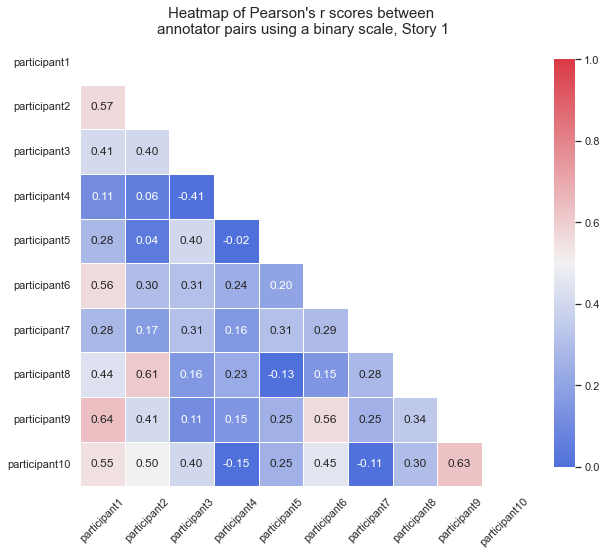

In [343]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          pearsons_values,
                                                          annotators,
                                                          "Heatmap of Pearson's r scores between \n annotator pairs using a binary scale, Story 1 ")



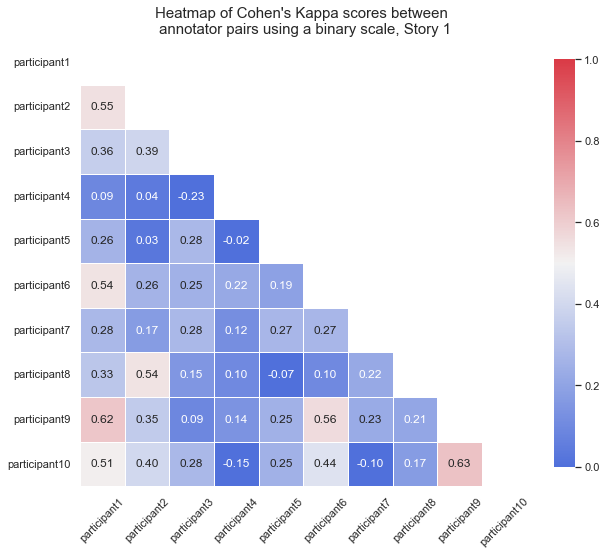

In [344]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          CKappa_values,
                                                          annotators,
                                                          "Heatmap of Cohen's Kappa scores between \n annotator pairs using a binary scale, Story 1")



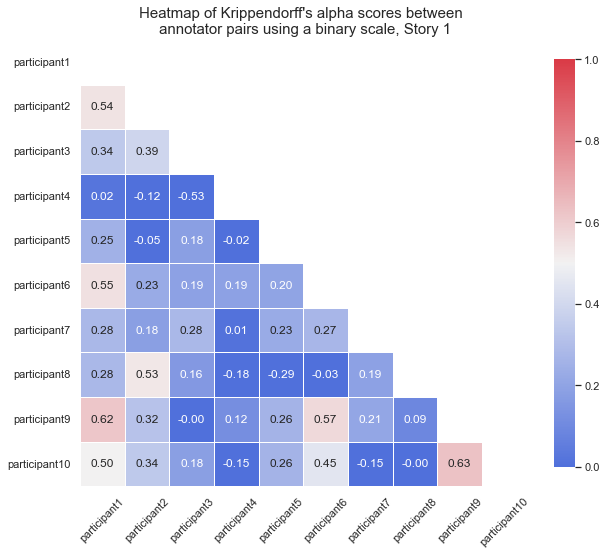

In [345]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9",
              "participant10"]

heatmap = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          KA_values,
                                                          annotators,
                                                          "Heatmap of Krippendorff's alpha scores between \n annotator pairs using a binary scale, Story 1")

